In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import FactorAnalysis
from sklearn.linear_model import LogisticRegression

collected 3111 input samples
collected 3111 target samples


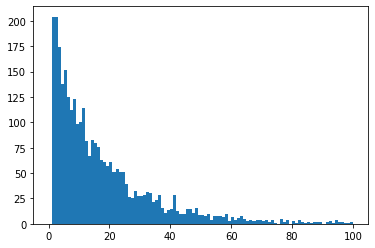

In [36]:
# parse data to end at affect

data = pd.read_csv('affect_behavior_action_clips.csv')
data = data.sort_values(['user_id.x', 'time_sequence', 'assignment_id.x', 'start_time', 'attemptcount']).reset_index()

input_names = ['time_taken', 'correct', 'original', 'hint', 'hintcount', 'total_hints', 'scaffold', 'bottom_hint', 'attemptcount', 'no_prob_type', 'algebra', 'choose_1', 'choose_n', 'fill_in_1', 'open_response']
target_names = ['confusion', 'concentration', 'boredom', 'frustration']

input_data = []
target_data = []
sequence_lengths = []

start = 0
last_assignment_id = 0
for i, row in data.iterrows():
    if last_assignment_id != row['assignment_id.x']:
        start = i
        last_assignment_id = row['assignment_id.x']
    if not np.isnan(data.iloc[i]['confusion']):
        sequence_lengths.append(i+1 - start)
        input_data.append(data.iloc[start:i+1][input_names].fillna(0).values)
        target_data.append(data.iloc[i][target_names].values)

print(f'collected {len(input_data)} input samples')
print(f'collected {len(target_data)} target samples')
plt.figure()
plt.hist(sequence_lengths, np.arange(101))
plt.show()

In [ ]:
pooling = []
dimention = []
score = []

for pooling_name, pooling_function in zip(['Max Pooling', 'Mean Pooling'], [np.max, np.mean]):
    for dim in np.power(2, np.arange(17)):
        scores = []
        print(dim)
        for i in range(5):
            log_input = []
            random_embedding = (np.random.rand(len(input_names), dim) * 2 - 1) * np.sqrt(len(input_names))
            for i in input_data:
                embedded_input = np.dot(i, random_embedding)
                embedded_input = pooling_function(embedded_input, axis=0)
                log_input.append(embedded_input)
            log_input = np.stack(log_input)
            cvlr = LogisticRegressionCV(Cs=1, cv=10, scoring='roc_auc', max_iter=10000)
            each_score = []
            for t in np.array(target_data).T:
                t = t.astype('int')
                cvlr.fit(log_input, t)
                each_score.append(np.mean(cvlr.scores_[1]))
            scores.append(np.mean(each_score))
        pooling.append(pooling_name)
        dimention.append(dim)
        score.append(np.mean(scores))

1
2
4
8
16
32
64
128
256
512


In [ ]:
plt.figure()
plt.scatter(dimention, score, color='blue' if 'Max' in p else 'orange')
plt.show()

In [ ]:
# parse data to group by student-assignment-timesequence

data = pd.read_csv('affect_behavior_action_clips.csv')

input_names = ['time_taken', 'correct', 'original', 'hint', 'hintcount', 'total_hints', 'scaffold', 'bottom_hint', 'attemptcount', 'no_prob_type', 'algebra', 'choose_1', 'choose_n', 'fill_in_1', 'open_response']
target_names = ['confusion', 'concentration', 'boredom', 'frustration']

def convert(data):
    data = data.sort_values(['start_time', 'attemptcount'])
    parsed = pd.Series()
    parsed['input'] = data[input_names].values
    parsed['target'] = data[target_names].values
    return parsed

data = data.groupby(['user_id.x', 'time_sequence', 'assignment_id.x']).apply(convert).reset_index()
print(len(data))
data = data[~data['target'].apply(lambda x: np.all(np.isnan(x)))]
print(len(data))
plt.figure()
plt.hist(data['target'].apply(lambda x: x.shape[0]), np.arange(101))
plt.show